In [19]:
import torch 
import math
import matplotlib.pyplot as plt

In [9]:
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

p = torch.tensor([1, 2, 3]) # Polynomial order
xx = x.unsqueeze(-1).pow(p) # X vals before weights

model = torch.nn.Sequential(
    torch.nn.Linear(3, 1), # Weights for order p?
    torch.nn.Flatten(0, 1) # ? 
)
loss_fn = torch.nn.MSELoss(reduction='sum')

In [18]:
learning_rate = 1e-03
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
for t in range(2000):
    y_pred = model(xx)
    
    loss = loss_fn(y_pred, y)
    if t % 100 == 99: 
        print(t, loss.item())
        
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()

linear_layer = model[0]
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} xx^2 + {linear_layer.weight[:, 2].item()} x^3')

99 8.817176818847656
199 8.817168235778809
299 8.817167282104492
399 8.817167282104492
499 8.817169189453125
599 8.817168235778809
699 8.817168235778809
799 8.817167282104492
899 8.817168235778809
999 8.817168235778809
1099 8.817167282104492
1199 8.817167282104492
1299 8.817168235778809
1399 8.817167282104492
1499 8.817167282104492
1599 8.817167282104492
1699 8.817167282104492
1799 8.817167282104492
1899 8.817167282104492
1999 8.817169189453125
Result: y = -2.980587169076898e-06 + 0.8567398190498352 x + -2.9657271625183057e-06 xx^2 + -0.09333141148090363 x^3


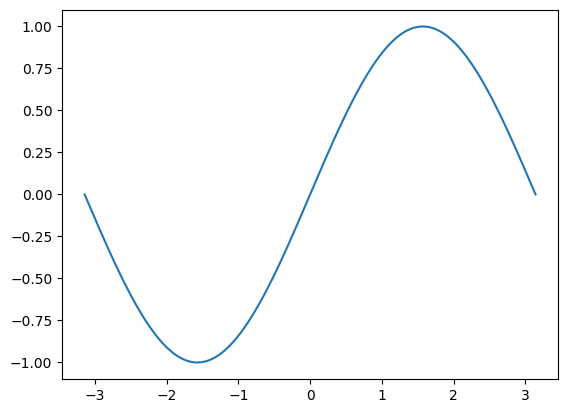

<built-in method detach of Tensor object at 0x000002999DEA41D0>


In [30]:
plt.figure()
plt.plot(x, y)
# plt.plot(xx, y_pred)
plt.show()
print(y_pred.detach)